# **GMM over Spark**

Last update: 02/04/2019 (updated to Python 3)

Created by: Vanessa Gömez Verdejo (vanessa@tsc.uc3m.es)

**Student 1: Niall O'Neill (100394545)**

**Student 2: Karolina Sidlauskaite (100392576)**

A [**Gaussian Mixture Models** (GMM)](https://brilliant.org/wiki/gaussian-mixture-model/) represents a composite distribution whereby points are drawn from one of K Gaussian sub-distributions. The probabilistic distribution of a data **x** is given by:

$$ p(\mathbf{x}) = \sum_k^K \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k) $$

$$ {\rm ~where~} \pi_k {\rm ~are~ the ~mixing ~~weights},~ \pi_k>0,~ \sum_k \pi_k =1.$$
$$\mathbf{\mu}_k {\rm ~and~} \mathbf{\Sigma}_k {\rm ~are ~the ~mean~and ~covariance ~matrix~of ~the ~k-th ~gaussian ~distribution}.$$

The GMM is one of the most common of probabilistic generative models and it can be used for both density estimation and clustering. Fitting the parameters of Mixture Models is usually carried out by means of the [**Expectation-Maximization (EM)**](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) algorithm which provides a simple iterative solution that guarantees to converge to a local mode.

In this notebook, let's work with this model over Spark. In particular, we will review the following concepts:

* **1. Introduction to GMM with MLLIB:**
  - Data generation
  - Learning a GMM with MLLib
  - Estimating the data likelihood
* **2. Model application: novelty detection**
* **3. Implementing the EM algorithm in Spark**

## 1. Introduction to GMM with MLLib

#### 1.1 Data generation

To start to work with the GMM model, the next cell generates a toy dataset of samples coming from a GMM and creates a RDD to work with this dataset over Spark.

Note: The GMM implementation of Spark only works with RDDs, so throughout this practice we will use this type of data instead of DataFrames.

In [5]:
import numpy as np

# Set a sedd to get similar results
np.random.seed(4)

# Define the number of samples
n_samples = 5000

# Let's create a bidimensional model with 2 gaussians. Define their means and covariance matrix
mean0 = [-2, -2]
mean1 = [2, 2]
sigma = np.eye(2)

data0  = np.random.multivariate_normal(mean0, sigma, n_samples//2)
data1  = np.random.multivariate_normal(mean1, sigma, n_samples//2)

data = np.vstack((data0,data1))
#Paralelizamos los datos
dataRDD = sc.parallelize(data)

**Exercise**: Complete the following code to provide the desired output.

In [7]:
#Complete the #FILL IN# gaps

# Compute the number of data in the RDD
numberData = dataRDD.count()
print("Total number of data: %d" %numberData)

# Get the first 5 data of the RDD
data5 = dataRDD.take(5)
print("The first 5 data are: %s" %data5)

Total number of data: 5000
The first 5 data are: [array([-1.94943829, -1.50004867]), array([-2.99590893, -1.30640149]), array([-2.41830152, -3.58457724]), array([-2.64770677, -1.40142483]), array([-1.66774997, -3.14747663])]

**_The answer should be_:**
<pre><code>
Total number of data: 5000
The first 5 data are: [array([-1.94943829, -1.50004867]), array([-2.99590893, -1.30640149]), array([-2.41830152, -3.58457724]), array([-2.64770677, -1.40142483]), array([-1.66774997, -3.14747663])]
</code></pre>

**Exercise**: To analyze the dataset in detail, the next cell gives you some lines of code to plot the data. Since we are supposed to be working with a large amount of data, we cannot collect the complete dataset to the driver, so let's randomly take 500 data and plot this subset in a two-dimensional space.

Note: Use the RDD method takeSample().

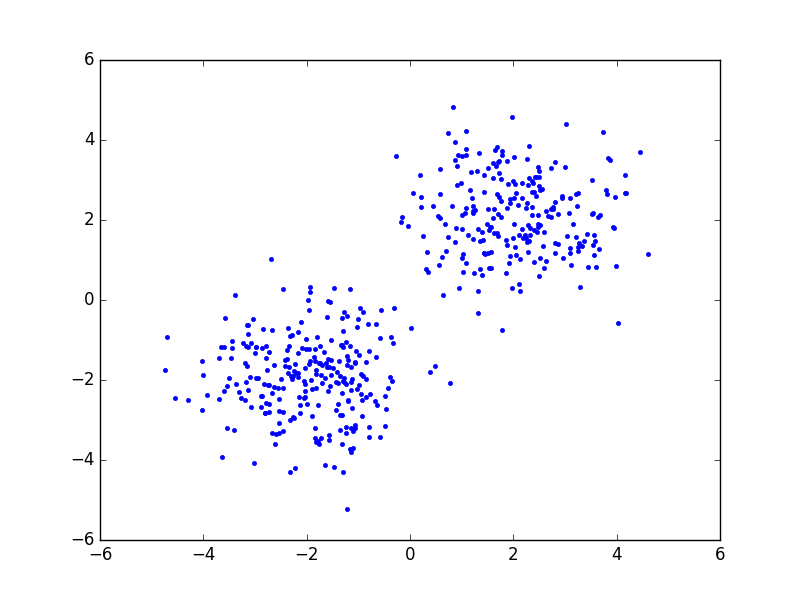

In [10]:
#Complete the #FILL IN# gaps

import matplotlib.pyplot as plt

# Take (at random) 500 data from dataRDD
data500 = dataRDD.takeSample(False,500)

# Note that you are getting a list of arrays, convert it to ndnumpy array (use np.array() method)
data500 = np.array(data500)

# Plot the data
fig = plt.figure()
plt.plot(data500[:,0],data500[:,1],'.')
display(fig)

**_The answer should be_:**
<pre><code>
<img src="http://www.tsc.uc3m.es/~vanessa/figsdatabricks/GMM0.png" width="400"/>
</code></pre>

#### 1.2 Learning a GMM with MLLib

Now, let's learn the underlying probability distribution of this dataset. For this purpose, let's use the [GaussianMixture object of MLLIB](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#gaussian-mixture).

This model can be called as:

gmmModel = GaussianMixture.train(rdd, k, convergenceTol=0.001, maxIterations=100, seed=None, initialModel=None)[source]

where:
* rdd – Training points as an RDD of Vector or convertible sequence types.
* k – Number of independent Gaussians in the mixture model.
* convergenceTol – Maximum change in log-likelihood at which convergence is considered to have occurred. (default: 1e-3)
* maxIterations – Maximum number of iterations allowed. (default: 100)
* seed – Random seed for initial Gaussian distribution. Set as None to generate seed based on system time. (default: None)
* initialModel – Initial GMM starting point, bypassing the random initialization. (default: None)


**Exercise**: Train a GMM for the dataRDD generated before, fixing k=2  and setting seed=1 (use the default values for the reamining parameters).

Note: This cell only trains the model and none output is generated.

In [13]:
#Complete the #FILL IN# gaps

from pyspark.mllib.clustering import GaussianMixture, GaussianMixtureModel

gmmModel = GaussianMixture.train(dataRDD,2,seed = 1)

**Analyze the output of the model**

The resulting [gmmModel](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.clustering.GaussianMixtureModel) has the following parameters:
* .k: Number of gaussians in mixture.
* .weights: Weights for each gaussian distribution in the mixture, where weights[i] is the weight for Gaussian i, and weights.sum == 1.
* .gaussian: Array of MultivariateGaussian where gaussians[i] represents the Multivariate Gaussian (Normal) Distribution for the i-th Gaussian. Each element of the array, gaussians[i], has two parameters:
  * .mu: mean of the gaussian distribution
  * .sigma: covariance matrix of the gaussian distribution
  
**Exercise**: Use this information to complete the following cell and analyze the learned model. 
Check if the parameters learned by the model match with those used to generate the data.

In [15]:
#Complete the #FILL IN# gaps

# Check output parameters of model
# Get the number of gaussians in the model
K= gmmModel.k
print("Number of gaussians %d" %K)
print("----------")

# For each gaussian
for i in range(K):
    print("Gaussian %d" %i)
    # Get the weight associated to each Gaussian distribution in the mixture
    w = gmmModel.weights[i]
    print("weight = %s" %w)
    # Get the mean of the i-th Gaussian
    mu = gmmModel.gaussians[i].mu
    print ("mu = %s" %mu)
    # Get the covariance matrix of the i-th Gaussian
    sigma =gmmModel.gaussians[i].sigma 
    print ("sigma = %s" %sigma.toArray())
    print("----------")

Number of gaussians 2
----------
Gaussian 0
weight = 0.499588708829
mu = [1.99809478028,1.99804110237]
sigma = [[ 0.99857662 0.00233737]
 [ 0.00233737 1.04104924]]
----------
Gaussian 1
weight = 0.500411291171
mu = [-1.99951629153,-1.98433624412]
sigma = [[ 0.94428854 -0.01510081]
 [-0.01510081 0.97834726]]
----------

**_The answer should be_:**
<pre><code>
Number of gaussians  2
----------
Gaussian  0
weight =  0.499588708829
mu =  [1.99809478028,1.99804110237]
sigma =  [[ 0.99857662  0.00233737]
 [ 0.00233737  1.04104924]]
----------
Gaussian  1
weight =  0.500411291171
mu =  [-1.99951629153,-1.98433624412]
sigma =  [[ 0.94428854 -0.01510081]
 [-0.01510081  0.97834726]]
</code></pre>

**Compute the data membership**

The gmmModel also has two additional methods:
* .predict: to find the cluster to which a new point (or for each point in an RDD) has maximum membership in this model.
* .predictSoft: to compute the membership of a new point (or for each point in an RDD) to all mixture components. 

**Exercise**:  The next cell provides you 4 example data points, compute both the membership of each data point to each gaussian and the maximum membership of the model.

In [18]:
#Complete the #FILL IN# gaps

# Create an RDD with 4 example data points
testDataRDD = sc.parallelize([np.array([ 1.50397636,  1.83196124]),
 np.array([-2.18957109,  -2.30737699]),
 np.array([-10.0,  10.0]),
 np.array([0.0 ,  0.0])])

# Compute the maximum membership of each data point
maxMembership= gmmModel.predict(testDataRDD)
print(maxMembership.collect())

# Compute the membership of each data point to each gaussian 
softMembership= gmmModel.predictSoft(testDataRDD)
print(softMembership.collect())


[0, 1, 0, 0]
[array('d', [0.9999991418624413, 8.581375586904735e-07]), array('d', [2.2038433622319005e-08, 0.9999999779615664]), array('d', [0.5, 0.5]), array('d', [0.5565069464261408, 0.4434930535738591])]

**_The answer should be_:**
<pre><code>
[0, 1, 0, 0]
[array('d', [0.9999991418624413, 8.581375586904735e-07]), array('d', [2.2038433622319005e-08, 0.9999999779615664]), array('d', [0.5, 0.5]), array('d', [0.5565069464261408, 0.4434930535738591])]
</code></pre>

**Note** that among the 4 example data, the first two could have been generated by the original model, but it is unlikely that the last two were generated by the same distribution that generated dataRDD. However, the functions .predict() and .Softpredict() assign them to one of the Gaussians and they do not indicate if they belong to it a high or low probability. 

This is due to the fact that the MLLIB GMM model is designed for clustering purposes (it assigns a data to the most likely cluster) and it is not intended for probability estimation (i.e., it doesn't provide the data probability under this model). In the next section, we will design the necessary functions to include this additional functionality.

#### 1.3 Estimating the model likelihood

Let's consider that a GMM model is given (or we have already learned it from a given data set), so the following set of parameters is known:

$$\mathbf{\theta}\triangleq[\pi_1, \ldots,\pi_K,\mathbf{\mu}_1,\ldots,\mathbf{\mu}_K,\mathbf{\Sigma}_1,\ldots,\mathbf{\Sigma}_K]$$

and our goal is to know with what probability this model has generated a sample data point **x**, that is, we want to compute:

$$ p(\mathbf{x}|\mathbf{\theta}) = \sum_k^K \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)$$

this is known as the model likelihood evaluated over the data **x**.

In this section we are going to implement some useful functions that will allow us to calculate the model likelihood of a given data set.

**Exercise**: Since the model likelihood for a given data **x** is given by the sum of a set of K Gaussian distributions, let's start by desingning a function, computeLikelihoodPerGauss(), which calculates the K probabilities of the data **x** on each of these Gaussian distributions, i.e.,

$$ [ \mathcal{N}(\mathbf{x}|\mathbf{\mu}_1,\mathbf{\Sigma}_1), \ldots,  \mathcal{N}(\mathbf{x}|\mathbf{\mu}_K,\mathbf{\Sigma}_K)]$$

The next cell gives you some code lines to calculate with what probability an example data has been generated by the first gaussian:

$$ p_1(\mathbf{x}|\mathbf{\theta}) = \mathcal{N}(\mathbf{x}|\mathbf{\mu}_1,\mathbf{\Sigma}_1)$$

Use this sample code to complete the function computeLikelihoodPerGauss().

In [23]:
# SAMPLE CODE: It computes the likelihood of the first gaussian of model over an example data

from scipy.stats import multivariate_normal

# Example data: You can try to change the data values to obtain different probabilities values
data=np.array([ -2,  -2])
# Get the model parameters (we are using the model trained in the previous section)
mu = gmmModel.gaussians[0].mu
sigma = gmmModel.gaussians[0].sigma.toArray()

print('Model parameters: %s, %s' %(mu, sigma))
# Define the gaussian distribution (with the previous parameters) and compute its probability over data
gauss= multivariate_normal(mu, sigma)
likelihood = gauss.pdf(data)

# Print the output
print('Gaussian_0 likelihood for data: %s' %likelihood)

Model parameters: [1.99809478028,1.99804110237], [[ 0.99857662 0.00233737]
 [ 0.00233737 1.04104924]]
Gaussian_0 likelihood for data: 2.50542430181e-08

In [24]:
#Complete the #FILL IN# gaps

def computeLikelihoodPerGaussian(gaussians, x):
  
    """Compute the likelihood of each gaussian for the data x
    Args:
      gaussians: list with the gaussians of the GMM. Each gaussian is an object with the mean and coviariance of the gaussian.
      x: numpy array with a data
    Returns: 
      vectorLikelihoods: numpy array with the likelihood of data over each gaussian of the GMM model
    """
    vectorLikelihoods = np.empty(len(gaussians)) 
    for i in range(len(gaussians)):
      
      mu = gaussians[i].mu
      sigma = gaussians[i].sigma.toArray()
      
      gauss= multivariate_normal(mu, sigma)
      likelihood = gauss.pdf(x)
      vectorLikelihoods[i] = likelihood
    
    return vectorLikelihoods 
      
  
    
# 1. Check the function over a data
data=np.array([ -1.5,  -0.5])
# Use the gaussian of the previous GMM model
gaussians = gmmModel.gaussians
# Compute the gaussians' likelihoods
likelihoodData =  computeLikelihoodPerGaussian(gaussians, data)
print('Gaussians likelihoods over a data: %s' %likelihoodData)


# 2. Check the function over an RDD
testDataRDD = sc.parallelize([np.array([ 1.5,  1.8]),
 np.array([-2.1,  -2.3]),
 np.array([-10.0,  10.0]),
 np.array([0.0 ,  0.0])])

RDDlikelihoods = testDataRDD.map(lambda x : computeLikelihoodPerGaussian(gaussians,x))
likelihoodRDDData = RDDlikelihoods.collect()
print('Gaussians likelihoods over RDD: %s' %likelihoodRDDData)

Gaussians likelihoods over a data: [ 1.73518956e-05 4.64812309e-02]
Gaussians likelihoods over RDD: [array([ 1.35319224e-01, 1.34496203e-07]), array([ 5.07317642e-09, 1.56460786e-01]), array([ 2.75170192e-46, 1.95606177e-47]), array([ 0.00313623, 0.00249522])]

**_The answer should be_:**
<pre><code>
Gaussians likelihoods over a data:  [  1.73518956e-05   4.64812309e-02]
Gaussians likelihoods over RDD:  [array([  1.35319224e-01,   1.34496203e-07]), array([  5.07317642e-09,   1.56460786e-01]), array([  2.75170192e-46,   1.95606177e-47]), array([ 0.00313623,  0.00249522])]
</code></pre>

**Exercise**: Using the function computeLikelihoodPerGaussian (), complete the code of the function computeGMMLikelihood() so that it calculates the likelihood of the GMM. Note that this likelihood is given by the weigthed sum of the gaussians' likehoods:
$$ p(\mathbf{x}|\mathbf{\theta}) = \sum_k^K \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)$$

In [27]:
#Complete the #FILL IN# gaps

def computeGMMLikelihood(gaussians, weights, x):
  
    """Compute the likelihood of the GMM model for the data x
    Args:
      gaussians: list with the gaussians of the GMM. Each gaussian is an object with the mean and coviariance of the gaussian.
      weights: weights for each Gaussian distribution in the GMM 
      x: numpy array with a data
    Returns: 
      Likelihood: likelihood of the GMM model over data
    """
    Likelihood = 0
    vectorLikelihoods = computeLikelihoodPerGaussian(gaussians, x)
    for i in range(len(weights)):
      Likelihood += weights[i] * vectorLikelihoods[i]
    return Likelihood
  

# 1. Check the function over a data
data=np.array([ -1.5,  -0.5])
# Use the gaussian of the previous GMM model
gaussians = gmmModel.gaussians
weights = gmmModel.weights
# Compute the gaussians' likelihoods
likelihoodData =  computeGMMLikelihood(gaussians, weights, data)
print('GMM likelihood over a data: %s' %likelihoodData)


# 2. Check the function over an RDD
testDataRDD = sc.parallelize([np.array([ 1.5,  1.8]),
 np.array([-2.1,  -2.3]),
 np.array([-10.0,  10.0]),
 np.array([0.0 ,  0.0])])

RDDlikelihoods = testDataRDD.map(lambda x: computeGMMLikelihood(gaussians, weights, x))
likelihoodRDDData = RDDlikelihoods.collect()
print('GMM likelihood over RDD: %s' %likelihoodRDDData)

GMM likelihood over a data: 0.0671925920588
GMM likelihood over RDD: [0.0011515584155658053, 0.00017002027932031552, 5.5194882136174792e-34, 0.14489892931960993]

**_The answer should be_:**
<pre><code>
GMM likelihood over a data:  0.0232684015601
GMM likelihood over RDD:  [0.067604023505349914, 0.078294746240264668, 1.4726027464313521e-46, 0.0028154602232752829]
</code></pre>

In some cases, calculating the likelihood values can provide numerical problems. Keep in mind that some data have a very low values and others have large values, so numerical problems may arise. To avoid this, it is quite common to calculate the log-likelihood values instead of the likelihood ones.

**Exercise**: Modify the previous functions to compute:
* The log-likelihood of each gaussian for a given data -> computeLogLikelihoodPerGaussian()
* The log-likelihood of the GMM model for a given data -> computeGMMLogLikelihood()

You may find useful the following functions:
* [logpdf( )](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html)  of the multivariate_normal distribution: computes  the log of the multivariate_normal probability density function.
* [logsumexp( )](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.misc.logsumexp.html): computes the log of the sum of exponentials of input elements.

In [30]:
#Complete the #FILL IN# gaps

def computeLogLikelihoodPerGaussian(gaussians, x):
  
    """Compute the log-likelihood of each gaussian for the data x
    Args:
      gaussians: list with the gaussians of the GMM. Each gaussian is an object with the mean and coviariance of the gaussian.
      x: numpy array with a data
    Returns: 
      vectorLogLikelihoods: numpy array with the log-likelihood of data over each gaussian of the GMM model
    """
    
    vectorLikelihoods = np.empty(len(gaussians)) 
    for i in range(len(gaussians)):
      
      mu = gaussians[i].mu
      sigma = gaussians[i].sigma.toArray()
      
      gauss= multivariate_normal(mu, sigma)
      likelihood = gauss.logpdf(x)
      vectorLikelihoods[i] = likelihood
    
    return vectorLikelihoods 
      

# 1. Check the function over a data
data=np.array([ -1.5,  -0.5])
# Use the gaussian of the previous GMM model
gaussians = gmmModel.gaussians
# Compute the gaussians' log-likelihoods
logLikelihoodData =  computeLogLikelihoodPerGaussian(gaussians, data)
print('Gaussians log-likelihoods over a data: %s' %logLikelihoodData)


# 2. Check the function over an RDD
testDataRDD = sc.parallelize([np.array([ 1.5,  1.8]),
 np.array([-2.1,  -2.3]),
 np.array([-10.0,  10.0]),
 np.array([0.0 ,  0.0])])

RDDlogLikelihoods = testDataRDD.map(lambda x: computeLogLikelihoodPerGaussian(gaussians,x))
logLikelihoodRDDData = RDDlogLikelihoods.collect()
print('Gaussians log-likelihoods over RDD: %s' %logLikelihoodRDDData)

Gaussians log-likelihoods over a data: [-10.9618088 -3.06870669]
Gaussians log-likelihoods over RDD: [array([ -2.00011867, -15.82172987]), array([-19.0992987 , -1.85494987]), array([-104.90669468, -107.55056622]), array([-5.76473507, -5.99337774])]

**_The answer should be_:**
<pre><code>
Gaussians log-likelihoods over a data:  [-10.9618088   -3.06870669]
Gaussians log-likelihoods over RDD:  [array([ -2.00011867, -15.82172987]), array([-19.0992987 ,  -1.85494987]), array([-104.90669468, -107.55056622]), array([-5.76473507, -5.99337774])]
</code></pre>

In [32]:
#Complete the #FILL IN# gaps
from scipy.misc import logsumexp

def computeGMMLogLikelihood(gaussians, weights, x):
  
    """Compute the log-likelihood of the GMM model for the data x
    Args:
      gaussians: list with the gaussians of the GMM. Each gaussian is an object with the mean and coviariance of the gaussian.
      weights: weights for each Gaussian distribution in the GMM 
      x: numpy array with a data
    Returns: 
      LogLikelihood: log-likelihood of the GMM model over data
    """
    Likelihood = 0
    vectorLikelihoods = computeLogLikelihoodPerGaussian(gaussians, x)
    
    Likelihood = logsumexp(vectorLikelihoods, b= weights)
    return Likelihood  

# 1. Check the function over a data
data=np.array([ -1.5,  -0.5])
# Use the gaussian of the previous GMM model
gaussians = gmmModel.gaussians
weights = gmmModel.weights
# Compute the gaussians' likelihoods
logLikelihoodData =  computeGMMLogLikelihood(gaussians, weights, data)
print ('GMM log-likelihood over a data: %s' %logLikelihoodData)


# 2. Check the function over an RDD
testDataRDD = sc.parallelize([np.array([ 1.5,  1.8]),
 np.array([-2.1,  -2.3]),
 np.array([-10.0,  10.0]),
 np.array([0.0 ,  0.0])])

RDDlogLikelihoods = testDataRDD.map(lambda x: computeGMMLogLikelihood(gaussians,weights,x))
logLikelihoodRDDData = RDDlogLikelihoods.collect()
print('GMM log-likelihood over RDD: %s' %logLikelihoodRDDData)

GMM log-likelihood over a data: -2.70019227475
GMM log-likelihood over RDD: [-6.7666391100156096, -8.6795928379090093, -76.579608020731214, -1.9317188187814203]

**_The answer should be_:**
<pre><code>
GMM log-likelihood over a data:  -3.76065899504
GMM log-likelihood over RDD:  [-2.6940877783945125, -2.5472747760620225, -105.53188286675339, -5.8726295411352369]
</code></pre>

Following code allows you plot the GMM negative log-likelihood over a bidimensional space

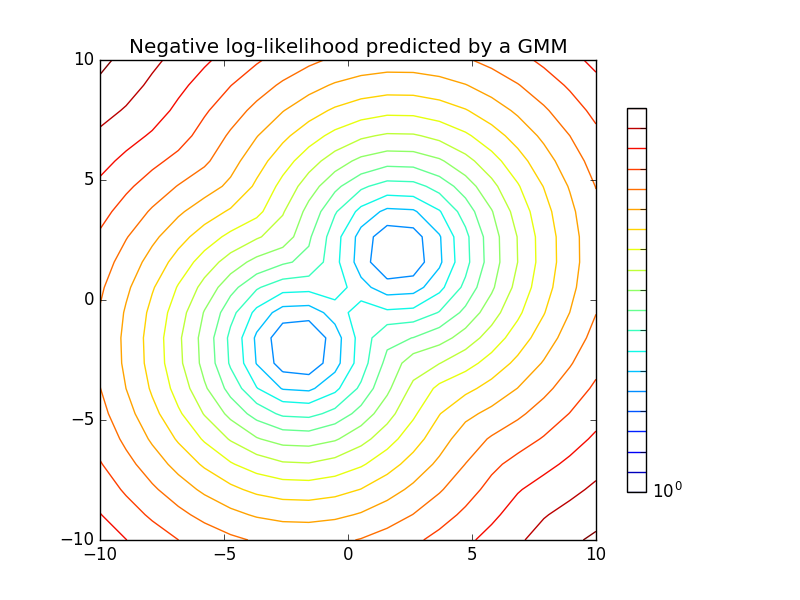

In [35]:
# display predicted scores by the model as a contour plot
from matplotlib.colors import LogNorm

x = np.linspace(-10., 10.,20)
y = np.linspace(-10., 10.,20)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

gaussians = gmmModel.gaussians
weights= gmmModel.weights
Z =np.array([-computeGMMLogLikelihood(gaussians, weights,xx) for xx in XX])
Z = Z.reshape(X.shape)

fig = plt.figure()
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1, vmax=100.0),
                 levels=np.logspace(0, 2, 20))
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
display(fig)

## 2. Model application: novelty detection

Many applications need to decide whether a sample belongs to the same distribution as the existing data or it must be considered different (it is an outlier). We can consider two scenarios:
* Novelty detection: We learn a density model wiht the training data and we are interested in detecting anomalies in new observations.
* Outlier detection: The training data contains outliers, and we must density distribution of the training data and detect the deviated observations, i.e., the data that are less likely to have been generated by the predominant distribution of training data. Often, this capability is used to clean real data sets.

In this section, we are going to apply the GMM to learn the data distribution of a given data set and, later, clean this dataset by detecting possible outliers.

##### 1. Load data

In this section, let's work with the dataset provided in the file "outlier_data.txt". To work with this file, we firstly have to upload the  file to Databricks:
* Go to Data (on left bar menu) and press over the sign '+' of Tables (new table)
* Select:
  - Data source: 'Upload File' (default option)
  - Upload to DBFS: don't do anything (we will use a default path)
  - File: drop or select the file 'outlier_data.txt'

Then, you will see "File uploaded to /FileStore/tables/outlier_data.txt". This indicates that the file has been sucessfully uploaded and it also provides you the path file ("/FileStore/tables/outlier_data.txt"). Now, go back to the notebook and run the following cell to create an RRD with the content of the text file. Note that the next cell is also parsing the data to create an array for each line of the file  and each one of these arrays becomes an element of your RDD.

In [38]:
import numpy as np

# Load and parse the data
data = sc.textFile("/FileStore/tables/outlier_data.txt")
dataRDD = data.map(lambda line: np.array([float(x) for x in line.strip().split(' ')]))

**Exercise**: Using the sample code of Section 1.1, randomly take 500 data from the RDD and plot this subset in a two-dimensional space.

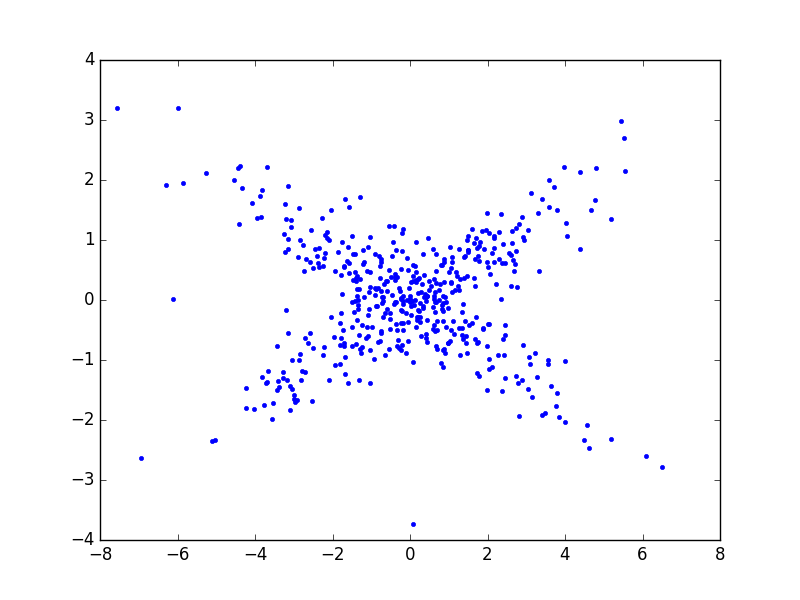

In [40]:
#Complete the #FILL IN# gaps

import matplotlib.pyplot as plt

# Take (at random) 500 data from dataRDD and convert it to ndnumpy array 
data500 = dataRDD.takeSample(False,500)
data500 = np.array(data500)

# Plot the data
fig = plt.figure()
plt.plot(data500[:,0],data500[:,1],'.')
display(fig)

**_The answer should be_:**
<pre><code>
<img src="http://www.tsc.uc3m.es/~vanessa/figsdatabricks/GMM1.png" width="400"/>
</code></pre>

Observing the data representation, how many Gaussians do you think you would need to adjust the distribution of the data?

##### 2. Learning GMM model 

Now, let's train a GMM to learn the underlying distribution of the data set.

**Exercise**: Using the code of Section 1.2, train a GMM with dataRDD (fix K=2, set the seed to 1, and leave the rest of the parameters to their default values). Examine the learned model parameters and discuss if their values match with the expected values.

In [44]:
#Complete the #FILL IN# gaps
from pyspark.mllib.clustering import GaussianMixture, GaussianMixtureModel

# Train the GMM
gmmModel = GaussianMixture.train(dataRDD,2,seed = 1)

# Check output parameters of model
# Get the number of gaussians in the model
K= gmmModel.k
print("Number of gaussians %d" %K)
print("----------")

# For each gaussian
for i in range(K):
    print("Gaussian %d" %i)
    # Get the weight associated to each Gaussian distribution in the mixture
    w = gmmModel.weights[i]
    print("weight = %s" %w)
    # Get the mean of the i-th Gaussian
    mu = gmmModel.gaussians[i].mu
    print ("mu = %s" %mu)
    # Get the covariance matrix of the i-th Gaussian
    sigma = gmmModel.gaussians[i].sigma
    print ("sigma = %s" %sigma.toArray())
    print("----------")

Number of gaussians 2
----------
Gaussian 0
weight = 0.536658982145
mu = [-0.0779665588778,0.0319828234734]
sigma = [[ 5.1599919 -1.90051554]
 [-1.90051554 1.00973553]]
----------
Gaussian 1
weight = 0.463341017855
mu = [0.0764761831323,0.0127056387766]
sigma = [[ 4.84433782 1.91735811]
 [ 1.91735811 0.94582474]]
----------

**_The answer should be_:**
<pre><code>
Number of gaussians  2
----------
Gaussian  0
weight = 0.536658982145 
mu = [-0.0779665588778,0.0319828234734] 
sigma = [[ 5.1599919 -1.90051554] 
[-1.90051554 1.00973553]]
----------
Gaussian  1
weight = 0.463341017855 
mu = [0.0764761831323,0.0127056387766] 
sigma = [[ 4.84433782 1.91735811] 
[ 1.91735811 0.94582474]]
----------
</code></pre>

##### 3. Outlier detection

Now let's compute the model log-likelihood over each data of the dataset and find the data with the least probability of being generated by the GMM model.

**Exercise**: complete the following code, using the functions implemented in Section 1.3, to complete the GMM log-likelihood of each data in dataRDD and find the 10 data with the lowest log-likelihood (i.e., the 10 most likely data to be outliers).

Note: you may need the method takeOrdered() of the RDD.

In [47]:
#Complete the #FILL IN# gaps

# Extract the gaussians and weigths of the GMM model
gaussians = gmmModel.gaussians
weights= gmmModel.weights

# Compute the GMM log-likelihood over dataRDD. Create as output a new RDD with tuples (data, log-likelihood)
RDDLogLikelihoods = dataRDD.map(lambda x: (x, computeGMMLogLikelihood(gaussians, weights, x)))
print('Example of the new RDD', RDDLogLikelihoods.first())

# Find the 10 data with lower log-likelihood
outliers = RDDLogLikelihoods.takeOrdered(10, key = lambda x: x[1])
print('The 10 outliers are:', outliers)


Example of the new RDD (array([ 2.59470454, 2.12298217]), -6.5287305489229803)
The 10 outliers are: [(array([ 0.09408561, -5.38938137]), -49.039512535719709), (array([ 9.12973772, 0.01494739]), -29.289925560210396), (array([ 0.07475756, -3.72503752]), -24.805195858129462), (array([ 8.19871928, 0.00982429]), -24.116629461888458), (array([ 7.55820383e+00, -6.47992466e-03]), -20.767416912485313), (array([-6.9801447 , 0.07165119]), -17.42043741355651), (array([ 6.53040133, 0.01067131]), -16.322499450866061), (array([-6.12758116, 0.02153393]), -14.330539353114368), (array([ 4.94016965e+00, -4.78939230e-03]), -10.422561280027622), (array([-7.75688143, -3.65219926]), -9.7432406840935357)]

**_The answer should be_:**
<pre><code>
Example of the new RDD [ 2.59470454 2.12298217], -6.52873054892 
The 10 outliers are: [(array([ 0.09408561, -5.38938137]), -49.039512535719709), (array([ 9.12973772, 0.01494739]), -29.289925560210396), (array([ 0.07475756, -3.72503752]), -24.805195858129462), (array([ 8.19871928, 0.00982429]), -24.116629461888458), (array([ 7.55820383e+00, -6.47992466e-03]), -20.767416912485313), (array([-6.9801447 , 0.07165119]), -17.42043741355651), (array([ 6.53040133, 0.01067131]), -16.322499450866061), (array([-6.12758116, 0.02153393]), -14.330539353114368), (array([ 4.94016965e+00, -4.78939230e-03]), -10.422561280027622), (array([-7.75688143, -3.65219926]), -9.7432406840935357)]
</code></pre>

##### 4. Plot the result

**Exercise**: Finally, let's plot the result. So using the sample code of Sections 1.1 (to plot the training data) and 1.3 (to plot the GMM negative log-likelihood), plot into a single figure:
* the GMM negative log-likelihood
* 500 data (at random) from the training data (in blue color)
* the detected outliers (in red color)

In [50]:
print(outliers)

[(array([ 0.09408561, -5.38938137]), -49.039512535719709), (array([ 9.12973772, 0.01494739]), -29.289925560210396), (array([ 0.07475756, -3.72503752]), -24.805195858129462), (array([ 8.19871928, 0.00982429]), -24.116629461888458), (array([ 7.55820383e+00, -6.47992466e-03]), -20.767416912485313), (array([-6.9801447 , 0.07165119]), -17.42043741355651), (array([ 6.53040133, 0.01067131]), -16.322499450866061), (array([-6.12758116, 0.02153393]), -14.330539353114368), (array([ 4.94016965e+00, -4.78939230e-03]), -10.422561280027622), (array([-7.75688143, -3.65219926]), -9.7432406840935357)]

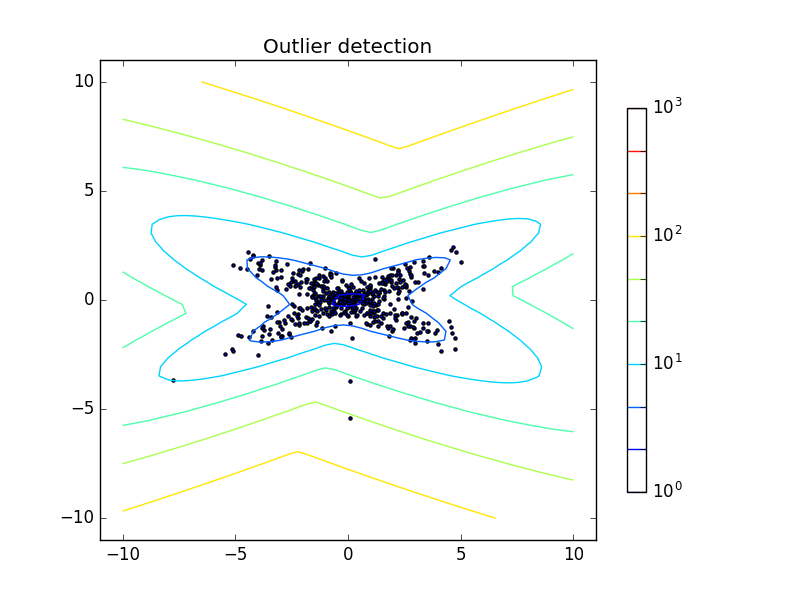

In [51]:
# Take (at random) 500 data from dataRDD
data500 = dataRDD.takeSample(False,500)
# Note that you are getting a list of arrays, convert it to ndnumpy array (use np.array() method)
data500 = np.array(data500)

x = np.linspace(-10., 10.,50)
y = np.linspace(-10., 10.,50)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z =np.array([-computeGMMLogLikelihood(gaussians, weights,xx) for xx in XX])
Z = Z.reshape(X.shape)

fig = plt.figure()
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(data500[:,0],data500[:,1], marker='.')

plt.title('Outlier detection')
plt.axis('tight')
display(fig)

**_The answer should be_:**
<pre><code>
<img src="http://www.tsc.uc3m.es/~vanessa/figsdatabricks/GMM2.png" width="400"/>
</code></pre>

## 3.HOMEWORK: Implementing the EM algorithm in Spark

The [Expectation–Maximization (EM)](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) algorithm is an iterative method to find maximum likelihood estimates of parameters in statistical models. To apply this algorithm to the GMM, let's imagine we are given a dataset 
$$\{\mathbf{x}^{(i)}\},~~ i=1,\ldots,N,$$
and we want to fit a GMM to explain this data set. So, for a given number K of components, our goal is to find the parameters $$\mathbf{\theta}\triangleq[\pi_1, \ldots,\pi_K,\mathbf{\mu}_1,\ldots,\mathbf{\mu}_K,\mathbf{\Sigma}_1,\ldots,\mathbf{\Sigma}_K]$$
to maximize the **log-likelihood of the observed data**:

$$
\ell(\mathbf{\theta}) = \sum_{i}^{N} \log p(\mathbf{x}^{(i)}|\mathbf{\theta}) 
$$

$$
\ell(\mathbf{\theta}) = \sum_{i}^{N} \log \left[  \sum_k^K \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k) \right]
$$ 

Unfortunately this is hard to optimize, since the log cannot be pushed inside the sum. To solve this problem,  a latent variable **z** is introduced indicating that the data **x** has been generated by the k-th component or distribution. In this way, this latent variable has a 1-of-K representation in which the element k-th is equal to 1 and all other elements are equal to 0, and its marginal distribution is given by

$$
p(\mathbf{z}) = \prod_k^K \pi_k^{z_k}
$$

and, therefore, the conditional distribution of **x** given **z** can be written in the form

$$
p(\mathbf{x}| \mathbf{z}) =  \prod_k^K  \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)^{z_k}
$$

and the marginal distribution of **x** can be recovered by summing the joint distribution of **x** and **z** over alll possible states of **z** to give a gaussian mixture:

$$
p(\mathbf{x}) = \sum_z p(\mathbf{x}| \mathbf{z}) p(\mathbf{z}) = \sum_k^K \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)
$$


To compute the model parameters, the **Expectation Maximization (EM)** algorithm defines the **complete data log likelihood** as

$$\ell_c(\mathbf{\theta})=\sum_i^{N} \log  p(\mathbf{x}^{(i)},z^{(i)}|\mathbf{\theta})$$

and, as the latent variable **z** is unknown, the EM computes the expected value of the complete data log likelihood under the posterior distribution of the latent variables (this is the E-step) and it later maximizes this expected log-likelihood (M-step).

The steps of the EM algorithm are:
1. Choose a initial setting for the parameters:
  $$\mathbf{\theta}^{old}\triangleq[\pi^{old}_1, \ldots,\pi^{old}_K,\mathbf{\mu}^{old}_1,\ldots,\mathbf{\mu}^{old}_K,\mathbf{\Sigma}^{old}_1,\ldots,\mathbf{\Sigma}^{old}_K]$$

2. **E-step**: Compute the posterior distribution of the latent variable using the current parameter values. These probabilities are known are the **responsabilities** :
$$\mathbf{\gamma}(\mathbf{z}^{(i)})=p(\mathbf{z}^{(i)}|\mathbf{x}^{(i)},\mathbf{\theta}^{old})$$
and are given by:
$$\gamma(z^{(i)}_{k}) = \frac{\pi_k \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_k,\mathbf{\Sigma}_k) }{\sum_j^K \pi_j \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_j,\mathbf{\Sigma}_j) }$$
This value can be viewed as the responsility the component *k* takes for explaining the observation **x**.
3. **M-step**: Compute the expected value of the complete data log likelihood and maximize it to reestimate the new values of the parameters:
$$ \mathbf{\mu}^{new}_k = \frac{1}{N_k} \sum_i^N  \gamma(z^{(i)}_k) \mathbf{x}^{(i)} $$
$$ \mathbf{\Sigma}^{new}_k = \frac{1}{N_k} \sum_i^N  \gamma(z^{(i)}_k) (\mathbf{x}^{(i)} -\mathbf{\mu}^{new}_k)(\mathbf{x}^{(i)} -\mathbf{\mu}^{new}_k)^T $$
$$ \pi^{new}_k = \frac{N_k}{N} $$
where
$$ N_k = \sum_i^N  \gamma(z^{(i)}_k) $$

4. Evaluate the log likelihood
$$ \sum_i^{N} \log  p(\mathbf{x}^{(i)}|\mathbf{\theta}) = \sum_i^{N} \log \left( \sum_k^K \pi_k \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_k,\mathbf{\Sigma}_k) \right)$$
and check the convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied return to Step 2.

In this section we will implement the EM algorithm over Spark (in a distributed way), following the steps described in the previous cell (Steps 1 to 4). In the following cells, you will have to complete several exercises to implement each of these steps. To check the method funcionality, we will run the algorithm over the toy problem that is created in the next cell.

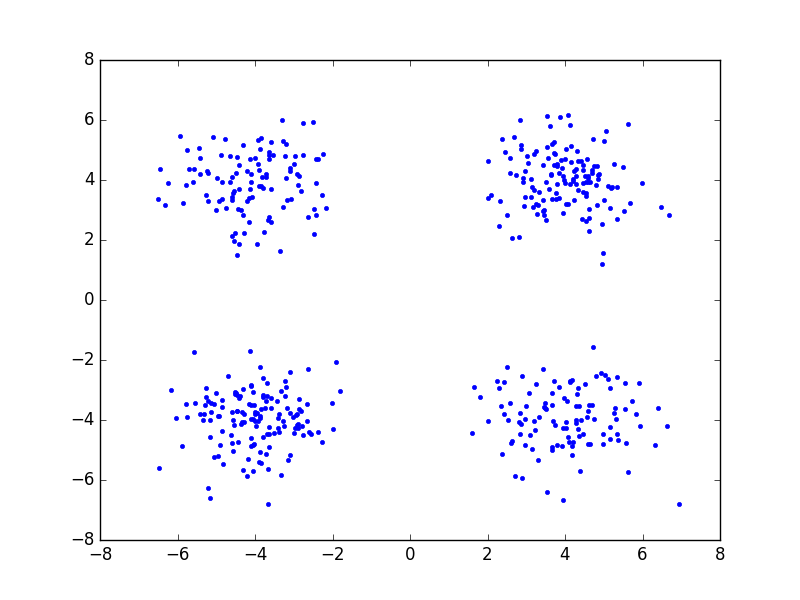

In [56]:
import numpy as np
import matplotlib.pyplot as plt

## Toy problem generation

# Set a seed to get similar results
np.random.seed(10)

# Number of samples
n_samples = 2000

# We generate 4 bidimensional data subsets with different gaussian parameters
K = 4
data0 = np.vstack((np.random.randn(n_samples/K) + 4,np.random.randn(n_samples/K) + 4)).T
data1 = np.vstack((np.random.randn(n_samples/K) - 4,np.random.randn(n_samples/K) + 4)).T
data2 = np.vstack((np.random.randn(n_samples/K) - 4,np.random.randn(n_samples/K) - 4)).T
data3 = np.vstack((np.random.randn(n_samples/K) + 4,np.random.randn(n_samples/K) - 4)).T
# Combine all the subsets
data = np.vstack((data0,data1,data2,data3))

# Parallelize the data
dataRDD = sc.parallelize(data)


## Plot the data

# Take (at random) 500 data from dataRDD
data500 = dataRDD.takeSample(withReplacement=False, num=500)

# Note that you are getting a list of arrays, convert it to numpy array (use np.array() method)
data500 = np.array(data500)

# Plot the data
fig = plt.figure()
plt.plot(data500[:,0],data500[:,1],'.')
display(fig)

##### 1. Initial setting of the parameters

**Exercise**: Complete the following cell to set the initial values of the GMM parameters. Note that the cell is designed to use the MultivariateGaussian object to define the mean and covariance matrix of each gaussian.

Useful functions:
* [np.random.rand()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html)
* [np.random.randn()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html)
* [np.eye()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html)
* [MultivariateGaussian](https://spark.apache.org/docs/2.1.2/api/python/pyspark.mllib.html#pyspark.mllib.stat.MultivariateGaussian)

In [58]:
#Complete the #FILL IN# gaps

from pyspark.mllib.linalg import Vectors, DenseMatrix
from pyspark.mllib.stat import MultivariateGaussian

# Set a seed to get similar results
np.random.seed(1)

def initializeGMM(dataRDD, K):
    """Initialize the  GMM model parameters (gaussians, weights) and compute some useful parameter
    Args:
      dataRDD: RDD with the data used to learn the model, each element is numpy array 
      K: number of gaussians of the GMM
    Returns: 
      gaussians: list with the gaussians of the GMM. Each gaussian is an object with the mean and coviariance of the gaussian.
      weights: weights for each Gaussian distribution in the GMM 
      D: data dimension
      N: number of data used to learn the model
    """
    # Compute data dimension
    D = dataRDD.first().size#FILL IN#
    # Precompute the number of data in dataRDD
    N = dataRDD.count()#FILL IN#

    # Initialize the weigths of each gaussian with a uniform value between 0 and 1 (use np.random.rand). Remember $0<\pi_k<1$ and $\sum_k         \pi_k =1$. weights has to be a vector of dimension K
    weights = np.random.rand(N, K)#FILL IN#
    weights = weights/weights.sum(axis=1, keepdims=True)
    
    gaussians = []
    for k in range(K):
      # For each gaussian, define the gaussian parameters (mean and covariances)

      # Initialize the means of each gaussian with a normal value with zero mean and unitary standard deviation (use np.random.randn)
      # Note that each mean is a vector of length D
      mu = np.random.randn(N, D)#FILL IN#

      # Initialize the covariances with the identity matrix (use np.eye). The covariance matrix has to be a matrix of dimension DxD.
      sigmaValues = np.eye(D)#FILL IN#  

      # Initialize the MultivariateGaussian object with the mean and covariace values (see MultivariateGaussian)
      myGauss = MultivariateGaussian(Vectors.dense(mu[k]), DenseMatrix(D, D, np.concatenate(sigmaValues))) #FILL IN#

      # Add the myGauss object to a list with the gaussians
      gaussians.append(myGauss) #FILL IN#
    
    return gaussians, weights, D, N

gaussians, weights, D, N = initializeGMM(dataRDD, 4)
print('weights: %s' %weights)
print('gaussians: %s' %gaussians)
print ('Number of data: %d' %N)

weights: [[ 2.89640161e-01 5.00297106e-01 7.94383512e-05 2.09983296e-01]
 [ 1.90365747e-01 1.19777854e-01 2.41609138e-01 4.48247261e-01]
 [ 1.94494029e-01 2.64126080e-01 2.05487686e-01 3.35892205e-01]
 ..., 
 [ 3.05842218e-01 3.02024987e-01 3.20227748e-01 7.19050474e-02]
 [ 1.10748044e-01 4.27822598e-01 3.12730636e-01 1.48698723e-01]
 [ 1.80233382e-01 2.53665835e-01 2.57264798e-01 3.08835985e-01]]
gaussians: [MultivariateGaussian(mu=DenseVector([1.4287, -1.1193]), sigma=DenseMatrix(2, 2, [1.0, 0.0, 0.0, 1.0], False)), MultivariateGaussian(mu=DenseVector([-1.134, -0.2749]), sigma=DenseMatrix(2, 2, [1.0, 0.0, 0.0, 1.0], False)), MultivariateGaussian(mu=DenseVector([-1.4202, 0.0642]), sigma=DenseMatrix(2, 2, [1.0, 0.0, 0.0, 1.0], False)), MultivariateGaussian(mu=DenseVector([-0.0196, 0.3625]), sigma=DenseMatrix(2, 2, [1.0, 0.0, 0.0, 1.0], False))]
Number of data: 2000

##### 2. E-step: Compute the responsabilities 

**Exercise**: Complete the following cell to desing a function able to compute the responsability vector associated to each data of the RDD (note that, for each data, the responsability vector has as many elements as number of centroids). Remember that the responsability of a data over the centroid *k* is given by:

$$\gamma(z_{k}) = \frac{\pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k) }{\sum_j^K \pi_j \mathcal{N}(\mathbf{x}|\mathbf{\mu}_j,\mathbf{\Sigma}_j) }$$

to compute the values of likelihood of each gaussian over the data **x** you can use the function computeLikelihoodPerGauss() designed in Section 1.3.

In [60]:
#Complete the #FILL IN# gaps

def computeResponsabilities(gaussians, weights, x):
  
    """Compute the responsability vector of the data x given the model parameters (gaussians, weights)
    Args:
      gaussians: list with the gaussians of the GMM. Each gaussian is an object with the mean and coviariance of the gaussian.
      weights: weights for each Gaussian distribution in the GMM 
      x: numpy array with a data
    Returns: 
      Resposabilities: numpy array with the responsabilities associated to data x
    """
    #########
    #FILL IN#
    likelihood = computeLikelihoodPerGaussian(gaussians, x)
    for i in range(len(weights)):
      weighted_likelihoods = weights[i]*likelihood
      responsabilities = weighted_likelihoods / weighted_likelihoods.sum(axis=0, keepdims=True)    
      return responsabilities
    #########

# Check the function over a data
x = dataRDD.first()
Responsabilities = computeResponsabilities(gaussians, weights, x)
print('Responsability vector over a data: %s' %Responsabilities)

Responsability vector over a data: [ 1.68323157e-01 8.78806955e-05 1.37980775e-08 8.31588948e-01]

**Exercise**: Use the previous function to compute the responsibilities of each data in dataRDD. Create a new RDD where each element has to be a tuple: (data, responsabilities).

In [62]:
#Complete the #FILL IN# gaps

# Compute the responsabilities over dataRDD
RDDResponsabilities = dataRDD.map(lambda x: (x, computeResponsabilities(gaussians, weights, x)))#FILL IN#

Responsabilities = RDDResponsabilities.take(5)   
print('Responsabilities over some data: %s' %Responsabilities)

Responsabilities over some data: [(array([ 5.3315865 , 5.43925373]), array([ 1.68323157e-01, 8.78806955e-05, 1.37980775e-08,
 8.31588948e-01])), (array([ 4.71527897, 5.38214662]), array([ 8.27446761e-02, 1.99745805e-04, 3.66946513e-08,
 9.17055541e-01])), (array([ 2.45459971, 4.92132043]), array([ 6.69110794e-03, 3.59174880e-03, 1.07789280e-06,
 9.89716065e-01])), (array([ 3.99161615, 3.42711278]), array([ 3.63934750e-01, 1.07705391e-03, 1.25421768e-07,
 6.34988070e-01])), (array([ 4.62133597, 5.2750491 ]), array([ 8.44757966e-02, 2.37001608e-04, 4.31300874e-08,
 9.15287159e-01]))]

##### 3. M-step: Reestimate the new values of the parameters
**Exercise**: Complete the following cell to desing a function able to update the values of the parameters. Remember that the parameter values are updated using the following expressions:

$$ \mathbf{\mu}^{new}_k = \frac{1}{N_k} \sum_i^N  \gamma(z^{(i)}_k) \mathbf{x}^{(i)} \quad \quad (1)$$
$$ \mathbf{\Sigma}^{new}_k = \frac{1}{N_k} \sum_i^N  \gamma(z^{(i)}_k) (\mathbf{x}^{(i)} -\mathbf{\mu}^{new}_k)(\mathbf{x}^{(i)} -\mathbf{\mu}^{new}_k)^T \quad \quad (2)$$
$$ \pi^{new}_k = \frac{N_k}{N} \quad \quad (3)$$
where
$$ N_k = \sum_i^N  \gamma(z^{(i)}_k) \quad \quad (4)$$

Keep in mind that these operations require calculating sums over all data or over some transformations of the data, remember that you can do it efficiently in Spark using correctly the operator reduce() or combining map() transformations with a final reduce().

In [64]:
#Complete the #FILL IN# gaps

def updateParameters(RDDResponsabilities):
    """Reestimate the GMM parameters (gaussians, weights)
    Args:
      RDDResponsabilities: RDD where each element is a tuple (x, responsability). x is a numpy array with a data and responsability a numpy                            array with the responsabilities associated to x.
    Returns: 
      gaussians: list with the gaussians of the GMM. Each gaussian is an object with the mean and coviariance of the gaussian.
      weights: weights for each Gaussian distribution in the GMM 
    """

    # Compute Nk, a vector with K values with the sum of the responsabilities associated to each gaussian (eq. (4))
    Nk = RDDResponsabilities.map(lambda x: x[1]).reduce(lambda x,y: x+y)#FILL IN#

    # Update the weigth values (eq. (3))
    weights_new = Nk/N#FILL IN#

    gaussians_new=[]
    for k in range(K): 
      # For each gaussian, we update its mean and covariance
      # \mu_k -> eq. (1)
      mu_k = (1/Nk[k])*RDDResponsabilities.map(lambda x: (x[1][k]*x[0])).reduce(lambda x,y: x+y)#FILL IN#
      # \sigma_k -> eq (2)
      sigma_k = (1/Nk[k])*RDDResponsabilities.map(lambda x: (x[1][k]*np.outer((x[0]-mu_k),(x[0]-mu_k).T))).reduce(lambda x,y: x+y)#FILL IN#
      
      # Save these values into a MultivariateGaussian object (see MultivariateGaussian)
      myGauss = MultivariateGaussian(Vectors.dense(mu_k), DenseMatrix(D, D, sigma_k.ravel()))#FILL IN#

      # Add the myGauss object to a list with the gaussians
      gaussians_new.append(myGauss)#FILL IN#

    return weights_new, gaussians_new

weights, gaussians= updateParameters(RDDResponsabilities)

print('weights: %s' %weights)
print('gaussians: %s' %gaussians)

weights: [ 3.29422872e-01 4.59476190e-01 3.46294715e-04 2.10754644e-01]
gaussians: [MultivariateGaussian(mu=DenseVector([4.102, -2.3227]), sigma=DenseMatrix(2, 2, [1.2123, 0.9311, 0.9311, 11.0269], False)), MultivariateGaussian(mu=DenseVector([-4.0512, -0.405]), sigma=DenseMatrix(2, 2, [0.9769, -0.1828, -0.1828, 16.5206], False)), MultivariateGaussian(mu=DenseVector([-4.4053, 3.6557]), sigma=DenseMatrix(2, 2, [0.9763, -0.218, -0.218, 5.1695], False)), MultivariateGaussian(mu=DenseVector([2.4783, 4.2096]), sigma=DenseMatrix(2, 2, [8.1495, -0.011, -0.011, 0.882], False))]

##### 4. Evaluate the log likelihood
**Exercise**: Complete the following function to be able to evaluate the log-likelihood over all training data:

$$ \sum_i^{N} \log  p(\mathbf{x}^{(i)}|\mathbf{\theta}) = \sum_i^{N} \log \left( \sum_k^K \pi_k \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_k,\mathbf{\Sigma}_k) \right)$$

You can use the function computeGMMLogLikelihood(), implemented in Section 1.3, which computes the log-likelihood over a given data.

In [66]:
#Complete the #FILL IN# gaps

def computeDataLogLikelihood(dataRDD, gaussians, weights):
    """Compute the log likelihood of a learned GMM over all training data
    Args:
       dataRDD: RDD with the data used to learn the model, each element is numpy array 
       gaussians: list with the gaussians of the GMM. Each gaussian is an object with the mean and coviariance of the gaussian.
       weights: weights for each Gaussian distribution in the GMM m
    Returns: 
       logLikelihood: log likelihood of the GMM, defined by gaussians, weights, computed over all training data in RDDdata
    """
    logLikelihood = dataRDD.map(lambda x: computeGMMLogLikelihood(gaussians, weights, x)).reduce(lambda x,y: x+y)
     #FILL IN#
    return logLikelihood
  
logLikelihood = computeDataLogLikelihood(dataRDD, gaussians, weights)
print('log-likelihood: %s' %logLikelihood)

log-likelihood: -9765.32564596

##### 5. Implementing EM algorithm
**Exercise**: Combine all steps of the EM algorithm to learn the GMM parameters (set the number of Gaussians to 4). Run the algorithm for 20 iterations. Analyze the evolution of the log-likelihood in each iteration and compare the parameters of the model with their real values (the values used to generate the data).

In [68]:
#Complete the #FILL IN# gaps

# Set a seed to get similar results
np.random.seed(0)

# 1. Initialize the GMM model (K=4)
gaussians, weights, D, N = initializeGMM(dataRDD, 4)  #FILL IN#

for iter in range(20):
  print('Iteration number: %d' %iter)
  # 2. E-step: Compute the responsabilities 
  RDDResponsabilities = dataRDD.map(lambda x: (x, computeResponsabilities(gaussians, weights, x)))  #FILL IN#

  # 3. M-step: Reestimate the new values of the parameters:
  weights, gaussians = updateParameters(RDDResponsabilities) #FILL IN#
  
  print('weights: %s' %weights)
  print('gaussians: %s' %gaussians)

  # 4. Evaluate the log likelihood
  logLikelihood = computeDataLogLikelihood(dataRDD, gaussians, weights)  #FILL IN#
  print('log-likelihood: %s' %logLikelihood)

Iteration number: 0
weights: [ 0.27617309 0.33008028 0.13456402 0.25918261]
gaussians: [MultivariateGaussian(mu=DenseVector([-3.8121, -3.6536]), sigma=DenseMatrix(2, 2, [2.5245, -0.5762, -0.5762, 3.7427], False)), MultivariateGaussian(mu=DenseVector([3.9146, -1.8189]), sigma=DenseMatrix(2, 2, [2.3276, -0.6315, -0.6315, 13.1742], False)), MultivariateGaussian(mu=DenseVector([-0.0303, 3.5875]), sigma=DenseMatrix(2, 2, [16.1168, -1.0732, -1.0732, 3.3055], False)), MultivariateGaussian(mu=DenseVector([-0.8664, 4.1047]), sigma=DenseMatrix(2, 2, [15.6289, -0.0739, -0.0739, 1.1519], False))]
log-likelihood: -9902.26376897
Iteration number: 1
weights: [ 0.25168452 0.3071034 0.18829776 0.25291433]
gaussians: [MultivariateGaussian(mu=DenseVector([-3.9995, -4.0026]), sigma=DenseMatrix(2, 2, [1.0001, 0.017, 0.017, 1.26], False)), MultivariateGaussian(mu=DenseVector([4.0053, -2.6433]), sigma=DenseMatrix(2, 2, [1.0248, 0.168, 0.168, 10.1548], False)), MultivariateGaussian(mu=DenseVector([-0.1435, 3.877]), sigma=DenseMatrix(2, 2, [16.8462, 0.1117, 0.1117, 1.1267], False)), MultivariateGaussian(mu=DenseVector([-0.7344, 4.0581]), sigma=DenseMatrix(2, 2, [16.29, 0.1294, 0.1294, 0.7187], False))]
log-likelihood: -9465.27417263
Iteration number: 2
weights: [ 0.25000035 0.28887374 0.22928823 0.23183769]
gaussians: [MultivariateGaussian(mu=DenseVector([-4.0027, -4.0393]), sigma=DenseMatrix(2, 2, [0.9775, 0.0267, 0.0267, 1.0394], False)), MultivariateGaussian(mu=DenseVector([4.0089, -3.0906]), sigma=DenseMatrix(2, 2, [1.027, 0.2069, 0.2069, 7.4985], False)), MultivariateGaussian(mu=DenseVector([-0.0862, 3.9129]), sigma=DenseMatrix(2, 2, [16.8537, 0.304, 0.304, 1.0118], False)), MultivariateGaussian(mu=DenseVector([-0.5475, 4.066]), sigma=DenseMatrix(2, 2, [16.5063, 0.0993, 0.0993, 0.7042], False))]
log-likelihood: -9427.18129654
Iteration number: 3
weights: [ 0.24998979 0.27076661 0.24067913 0.23856448]
gaussians: [MultivariateGaussian(mu=DenseVector([-4.0027, -4.0395]), sigma=DenseMatrix(2, 2, [0.9773, 0.0266, 0.0266, 1.0387], False)), MultivariateGaussian(mu=DenseVector([3.9999, -3.5563]), sigma=DenseMatrix(2, 2, [1.0595, 0.1491, 0.1491, 4.468], False)), MultivariateGaussian(mu=DenseVector([0.0403, 3.9093]), sigma=DenseMatrix(2, 2, [16.8691, 0.3583, 0.3583, 1.0029], False)), MultivariateGaussian(mu=DenseVector([-0.3412, 4.0621]), sigma=DenseMatrix(2, 2, [16.7441, -0.0099, -0.0099, 0.7286], False))]
log-likelihood: -9341.42000591
Iteration number: 4
weights: [ 0.24998075 0.25505497 0.24872589 0.24623839]
gaussians: [MultivariateGaussian(mu=DenseVector([-4.0029, -4.0395]), sigma=DenseMatrix(2, 2, [0.9769, 0.0267, 0.0267, 1.0387], False)), MultivariateGaussian(mu=DenseVector([3.9881, -3.972]), sigma=DenseMatrix(2, 2, [1.0909, 0.0722, 0.0722, 1.7113], False)), MultivariateGaussian(mu=DenseVector([0.1556, 3.8783]), sigma=DenseMatrix(2, 2, [16.8653, 0.3052, 0.3052, 1.01], False)), MultivariateGaussian(mu=DenseVector([-0.1809, 4.0426]), sigma=DenseMatrix(2, 2, [16.8855, -0.1791, -0.1791, 0.7609], False))]
log-likelihood: -9183.73759919
Iteration number: 5
weights: [ 0.24995795 0.25012086 0.25076945 0.24915175]
gaussians: [MultivariateGaussian(mu=DenseVector([-4.0032, -4.0395]), sigma=DenseMatrix(2, 2, [0.9758, 0.0268, 0.0268, 1.0388], False)), MultivariateGaussian(mu=DenseVector([3.9799, -4.0938]), sigma=DenseMatrix(2, 2, [1.1013, 0.0281, 0.0281, 0.9705], False)), MultivariateGaussian(mu=DenseVector([0.1885, 3.8528]), sigma=DenseMatrix(2, 2, [16.8805, 0.2663, 0.2663, 1.0332], False)), MultivariateGaussian(mu=DenseVector([-0.126, 4.0324]), sigma=DenseMatrix(2, 2, [16.9309, -0.2972, -0.2972, 0.7922], False))]
log-likelihood: -9145.99744375
Iteration number: 6
weights: [ 0.24993915 0.25005896 0.25007355 0.24992834]
gaussians: [MultivariateGaussian(mu=DenseVector([-4.0035, -4.0394]), sigma=DenseMatrix(2, 2, [0.9749, 0.0268, 0.0268, 1.0388], False)), MultivariateGaussian(mu=DenseVector([3.9793, -4.0955]), sigma=DenseMatrix(2, 2, [1.1027, 0.0266, 0.0266, 0.961